# Hyperparameter Tuning via Hyperopt

## RandomSearch

### Loading Libraries

In [21]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt

# StatsModel
from scipy.stats import randint,truncnorm

# Scikit-Learn
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

In [23]:
from hyperopt import fmin, rand, hp, STATUS_OK, Trials, plotting

### Loading Data

In [24]:
df = pd.read_csv("/Users/joaquinromero/Desktop/HPTP/data/train.csv", sep=";")

In [25]:
df['y'] = df['y'].map({'yes':1,'no':0})

### Train/Test Split

In [26]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

#### Placing Numerical Features

In [27]:
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

#### Placing Categorical Features

In [28]:
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

### Preprocessor

In [29]:
# Normalization Pre-processing for Numerical Features
numeric_preprocessor = StandardScaler()

# One-Hot-Encoding Pre-processing for Categorical Features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

In [30]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_feats),
        ("cat", categorical_preprocessor, categorical_feats),
    ]
)

### Pipeline

In [31]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", RandomForestClassifier(random_state=0))]
)

#### Placing All Features for Training Set

In [32]:
X_train_full = df_train.drop(columns=['y'])
y_train = df_train['y']

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40689 entries, 17974 to 2732
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40689 non-null  int64 
 1   job        40689 non-null  object
 2   marital    40689 non-null  object
 3   education  40689 non-null  object
 4   default    40689 non-null  object
 5   balance    40689 non-null  int64 
 6   housing    40689 non-null  object
 7   loan       40689 non-null  object
 8   contact    40689 non-null  object
 9   day        40689 non-null  int64 
 10  month      40689 non-null  object
 11  duration   40689 non-null  int64 
 12  campaign   40689 non-null  int64 
 13  pdays      40689 non-null  int64 
 14  previous   40689 non-null  int64 
 15  poutcome   40689 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


#### Placing All Features for Test Set

In [33]:
X_test_full = df_test.drop(columns=['y'])
y_test = df_test['y']

X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4522 entries, 14001 to 25978
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
dtypes: int64(7), object(9)
memory usage: 600.6+ KB


### Objective Function

In [34]:
def objective(space):
    estimator_clone = clone(pipe).set_params(**space)
    return {'loss': -1 * np.mean(cross_val_score(estimator_clone,
                                            X_train_full, y_train, 
                                            cv=5, scoring='f1',
                                            n_jobs=-1
                                            )
                            ), 
            'status': STATUS_OK}

### Hyperparameter Space

In [35]:
hyperparameter_space = { 
"model__n_estimators": 5 + hp.randint("n_estimators", 195), 
"model__criterion": hp.choice("criterion", ["gini", "entropy"]),
"model__class_weight": hp.choice("class_weight", ["balanced","balanced_subsample"]),
"model__min_samples_split": hp.loguniform("min_samples_split", np.log(0.0001), np.log(0.5))
} 

#### Defining Trials Object

In [36]:
trials = Trials()

### Performing Random Search

In [37]:
best = fmin(objective,
            space=hyperparameter_space,
            algo=rand.suggest,
            max_evals=100,
            rstate=np.random.default_rng(0),
            trials=trials,
           )

print(best)

100%|██████| 100/100 [02:44<00:00,  1.64s/trial, best loss: -0.6214817936837344]
{'class_weight': np.int64(0), 'criterion': np.int64(1), 'min_samples_split': np.float64(0.0004701700193524219), 'n_estimators': np.int64(186)}


In [38]:
pipe = pipe.set_params(**{'model__class_weight': "balanced",
                         'model__criterion': "entropy",
                         'model__min_samples_split': 0.00047017001935242104,
                         'model__n_estimators': 186})

In [39]:
pipe.fit(X_train_full,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        min_samples_split=0.00047017001935242104,
                                        n_estimators=186, random_state=0))])

### Test Data Evaluation

In [40]:
y_pred = pipe.predict(X_test_full)

print(f1_score(y_test, y_pred))

0.6189376443418014


avg best error: -0.6214817936837344


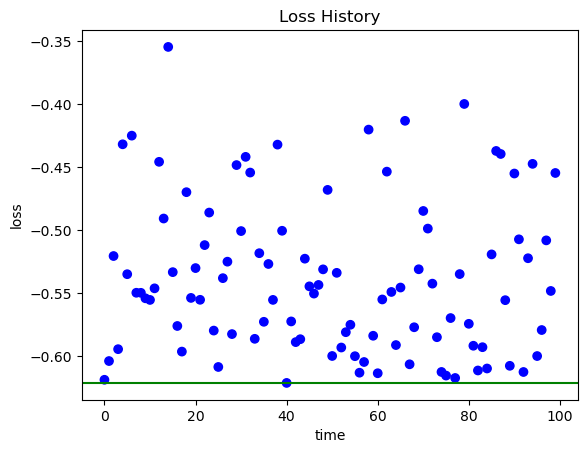

In [41]:
plotting.main_plot_history(trials)

Showing Histogram of 100 jobs


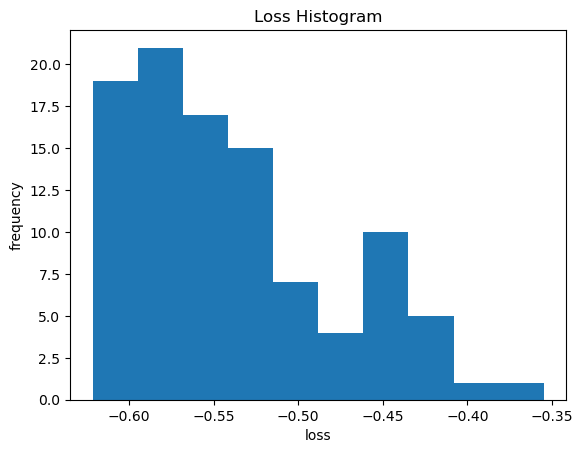

In [42]:
plotting.main_plot_histogram(trials)

finite loss range -0.6214817936837344 -0.3548202073435313 -1.6214817936837345


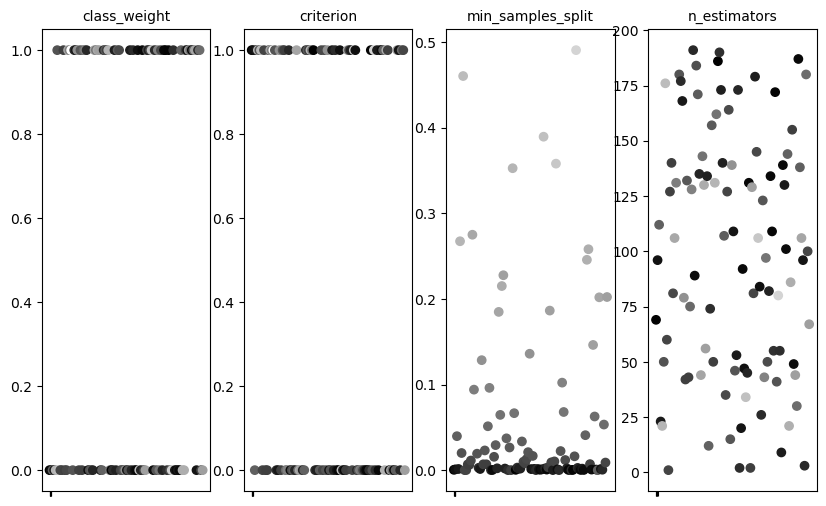

In [43]:
plt.figure(figsize=(10,6))
plotting.main_plot_vars(trials)
plt.show()